In [1]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pymc as pm
import pandas as pd
import polars as pl
import seaborn as sns
from statsmodels.stats.power import tt_ind_solve_power
%matplotlib inline
%load_ext autoreload
%autoreload 2
from src.simulations import *
from src.plotting import *
from src.modeling import *
#Convert effect sizes from r to Cohen's D 
r_to_d = lambda r: (2*r)/np.sqrt(1-r**2)

<h1>Psychology RPP</h1>

In [310]:
#Load RPP Data, randomize direction. 


df_psych = pl.read_csv('./data/rpp_data.csv',ignore_errors=True).filter(
    (pl.col('T_pval_USE..R.').is_not_null()) & 
    (pl.col('T_pval_USE..O.').is_not_null()) &
    (pl.col('T_r..R.').is_not_null()) &
    (pl.col('T_r..O.').is_not_null()) 
)

direction = np.random.choice(np.array([-1,1]), 
                             df_psych.shape[0])

df_psych = df_psych.with_column(
    (pl.lit(direction)).alias('direction')  
).with_columns([
    (r_to_d(pl.col('T_r..R.').cast(float))).alias("d_r"),
    (r_to_d(pl.col('T_r..O.').cast(float))).alias("d_o"),
    pl.col('N (R)').cast(int).alias("n_r"),
    pl.col('N (O)').cast(int).alias("n_o"),
]).with_column(
    (1 / np.sqrt(pl.col('n_o')) * sp.stats.norm.ppf(1 - .05/ 2)).alias('t_temp')
).with_column(
    (pl.col('t_temp') * pl.col('direction')).alias('t_c')
).select([
    'd_o','d_r','n_o','n_r','direction','t_c'
]).with_columns(
    [pl.when(pl.col('d_o')*pl.col('direction') > pl.col('t_c')).then(1000).otherwise(pl.col('t_c')).alias('upper'),
    pl.when(pl.col('d_o')*pl.col('direction') < pl.col('t_c')).then(-1000).otherwise(pl.col('t_c')).alias('lower'),
    ])

df_psych.head()

d_o,d_r,n_o,n_r,direction,t_c,upper,lower
f64,f64,i64,i64,i64,f64,f64,f64
1.479085,0.3,24,29,-1,-0.400076,-0.400076,-1000.0
1.544133,0.471814,24,24,1,0.400076,1000.0,0.400076
0.938971,-0.4408,25,32,-1,-0.391993,-0.391993,-1000.0
0.469938,-0.012217,240,270,-1,-0.126515,-0.126515,-1000.0
1.039851,0.272108,32,48,-1,-0.346476,-0.346476,-1000.0


In [359]:
idata_psych, m_psych = sample_publishing_model(df_psych.to_pandas(),
                                                                        prior={'s':2,
                                                                        't':2})

/var/folders/0v/xv9sbn1n1bsc6czmxyk4s62c3gqd75/T/ipykernel_72152/1948056752.py:32: FutureWarning: In this version, RNG seeding is managed by the Model objects. See the `rng_seeder` argument in Model's constructor.
  prior_checks = pm.sample_prior_predictive(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/joebak/anaconda3/envs/rs/lib/python3.10/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, signal]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
/var/folders/0v/xv9sbn1n1bsc6czmxyk4s62c3gqd75/T/ipykernel_72152/1948056752.py:50: FutureWarning: In this version, RNG seeding is managed by the Model objects. See the `rng_seeder` argument in Model's constructor.
  ppc = pm.sample_posterior_predictive(


In [360]:
az.summary(idata_psych, var_names=['tau','sigma',])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,0.807,0.083,0.66,0.970,0.002,0.001,2249.0,2349.0,1.0
sigma,0.598,0.055,0.50,0.704,0.001,0.001,1646.0,2378.0,1.0


In [361]:
make_summary_table(idata_psych, './output/tables/psych_posterior.tex')

/Users/joebak/github/ReplicationSurveys/src/modeling.py:82: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex(save_loc)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
index,,,,,,,,,
sigma,0.60,0.06,0.50,0.70,0.0,0.0,1646.0,2378.0,1.0
tau,0.81,0.08,0.66,0.97,0.0,0.0,2249.0,2349.0,1.0


In [362]:
from src.plotting import *

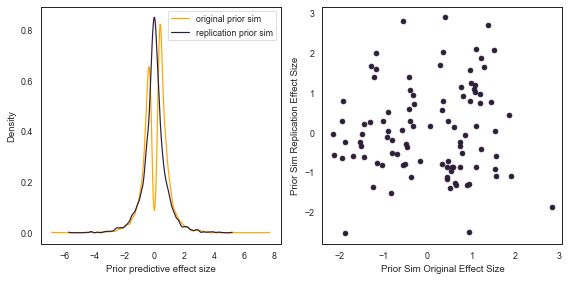

In [363]:
plot_prior_checks(idata_psych.prior_predictive, './output/figures/SIPriorRPP.png')

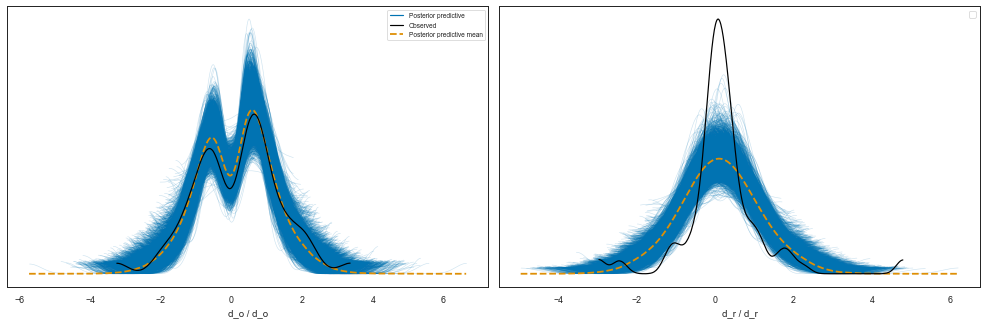

In [364]:
plot_posterior_distribution(idata_psych,save_loc='./output/figures/PosteriorDistributionRPP.png')

In [505]:
def simulate_reproducibility(row, i_data, pubs=1000, prob_sig=96.0 / 99.0):
    count = row[0]
    N = row[1]
    J = row[2]
    alpha = row[3]
    t_c = (1 / np.sqrt(N)) * sp.stats.norm.ppf(1 - alpha/ 2)

    out_p_success = np.zeros(J)
    out_p_rep_success = np.zeros(J)
    out_type_s = np.zeros(J)
    out_observed_es = np.zeros(J)
    out_true = np.zeros(J)
    out_reversal = np.zeros(J)
    out_d_reps = np.zeros(J)

    for jidx in range(J):
        chain = np.random.choice(4, 1)
        sample = np.random.choice(1000, 1)

        tau = i_data['posterior']['tau'].values[chain, sample]
        signals = np.abs(np.random.normal(0,tau,size=int(pubs))).ravel()
        sigma = i_data['posterior']['sigma'].values[chain, sample]

        d_orig = np.random.normal(signals, sigma)


        significant = np.random.binomial(1,
                                        tt_ind_solve_power(
                                        effect_size=d_orig,
                                        alpha=alpha,
                                        nobs1=np.int(N/2.0)))
        p_success = np.mean(significant)
        published = np.random.binomial(1,(prob_sig * significant) + (1 - prob_sig) * \
                                       (1 - significant))

        observed_es = d_orig[published == 1]
        actual_es = signals[published == 1]

        type_s = np.sign(signals) * d_orig < -t_c


        d_rep = np.random.normal(signals[published==1], sigma)


        p_rep_success = np.mean(np.random.binomial(1,
                                        tt_ind_solve_power(
                                        effect_size=d_rep,
                                        alpha=alpha/2.0,
                                        nobs1=np.int(N/2.0),
                                        alternative='larger')))

        reversal = np.random.binomial(1,
                                        tt_ind_solve_power(
                                        effect_size=d_rep,
                                        alpha=alpha/2.0,
                                        nobs1=np.int(N/2.0),
                                        alternative='smaller'))
        out_p_success[jidx] = p_success
        out_p_rep_success[jidx] = p_rep_success
        out_type_s[jidx] = np.mean(type_s)
        out_observed_es[jidx] = np.mean(observed_es)
        out_true[jidx] = np.mean(signals[published == 1])
        out_reversal[jidx] = np.mean(reversal)
        out_d_reps[jidx] = np.mean(d_rep)
    return    (np.mean(out_p_success),
                np.mean(out_p_rep_success),
                np.mean(out_type_s),
                np.mean(out_observed_es),
                np.mean(out_true),
                np.mean(out_reversal),
                np.mean(out_d_reps))
row = [1, 48, 100, .05]
simulate_reproducibility(row, idata_psych, pubs=10000, prob_sig=96.0 / 99.0)

/var/folders/0v/xv9sbn1n1bsc6czmxyk4s62c3gqd75/T/ipykernel_72152/264947049.py:31: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nobs1=np.int(N/2.0)))
/var/folders/0v/xv9sbn1n1bsc6czmxyk4s62c3gqd75/T/ipykernel_72152/264947049.py:49: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check 

(0.583962,
 0.5916258640560279,
 0.105347,
 0.9858224729344197,
 0.799889191842638,
 0.047108631785392534,
 0.8001779460937771)

In [537]:
from src.simulations import * 

In [538]:
out_psych = simulate(idata_psych,j=500,save_loc='./output/psych_sims.csv')

/Users/joebak/anaconda3/envs/rs/lib/python3.10/site-packages/polars/internals/frame.py:1097: UserWarning: 'to_csv' is deprecated. please use 'write_csv'
  warnings.warn("'to_csv' is deprecated. please use 'write_csv'")


In [539]:
out_psych.head()

publication_rate,replication_rate,type_s_error,published_es,actual_es,reversals,replication_es,N,j,alpha
f64,f64,f64,f64,f64,f64,f64,i64,i64,f64
0.076924,0.133501,0.017698,1.326023,0.977074,0.002445,0.978304,10,500,0.005
0.112884,0.177918,0.02246,1.308438,0.967418,0.004172,0.965797,10,500,0.01
0.254298,0.312203,0.044214,1.161906,0.882281,0.016273,0.883,10,500,0.05
0.351124,0.380966,0.058218,1.061726,0.8324,0.030384,0.8305,10,500,0.1
0.478572,0.468065,0.0792,0.956342,0.788492,0.055136,0.788452,10,500,0.2


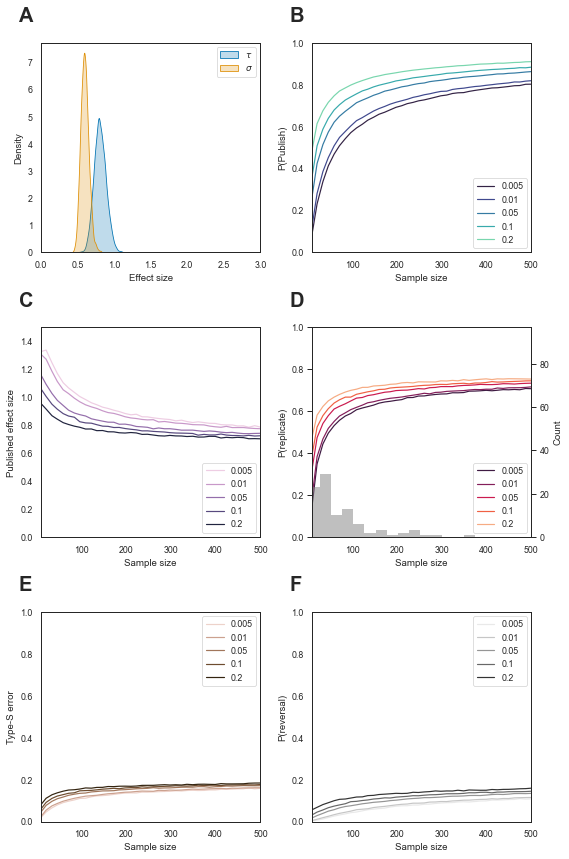

In [541]:
plot_sim_figure(idata_psych, out_psych.to_pandas(),
                df_psych.to_pandas(),plot_medians=False,
                save_loc='./output/figures/Figure4.png',max_effect=3)

#add average effect



<h3>Alternative Psychology Model</h3>

In [371]:
def alternate_publishing_model(df, prior={'s':.5,
                                        't':.5,
                                       'b':.5}):

    with pm.Model() as m_1:
        a_sigma = pm.Exponential('a_sigma', 2)
        b_sigma = pm.Gamma('b_sigma',mu=1, sigma=.5)

        #Hyperpriors
        tau = pm.Exponential("tau", prior['t'])

        #Priors
        signal = pm.Normal('signal', sigma=tau, shape=df.shape[0])

        s = a_sigma + b_sigma * pm.math.abs_(signal)

        #Epsilon
        s_o=pm.math.sqrt(pm.math.sqr(s)+ pm.math.sqr(1/pm.math.sqrt(df.n_o.values)))
        s_r=pm.math.sqrt(pm.math.sqr(s)+ pm.math.sqr(1/pm.math.sqrt(df.n_r.values)))
        #Model
        d_o = pm.TruncatedNormal("d_o",  mu=signal,
                                 sigma=s_o,
                                 lower=df.lower.values,
                                 upper=df.upper.values,
                                 observed=df.d_o*df.direction)
        d_r = pm.Normal("d_r", mu=signal, 
                        sigma=s_r,
                        observed=df.d_r*df.direction)

    with m_1:
        dims={
                "d_r": ["study"],
                "d_o": ["study"],
        }
        #Prior checks and sampling
        prior_checks = pm.sample_prior_predictive(
            samples=50, 
            random_seed=42,
            idata_kwargs={'dims':dims},

        )

        #Sampling
        idata_1 = pm.sample(
            idata_kwargs={'dims':dims},
            cores=4,
            nuts={"max_treedepth":12,
                  "target_accept":0.95}, 
            random_seed=42,
    
        )

        #Posterior Predictive Checks
        ppc = pm.sample_posterior_predictive(
            idata_1, 
            var_names=["d_o", "d_r"], 
            random_seed=42,
            idata_kwargs={'dims':dims}

        )

        idata_1.extend(ppc)
        idata_1.extend(prior_checks)
        
    return idata_1, m_1

In [372]:
idata_psych_alt, model_alt = alternate_publishing_model(df_psych.to_pandas(),
                                                                        prior={'s':2,
                                                                        't':2})

/var/folders/0v/xv9sbn1n1bsc6czmxyk4s62c3gqd75/T/ipykernel_72152/3407505438.py:37: FutureWarning: In this version, RNG seeding is managed by the Model objects. See the `rng_seeder` argument in Model's constructor.
  prior_checks = pm.sample_prior_predictive(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/joebak/anaconda3/envs/rs/lib/python3.10/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_sigma, b_sigma, tau, signal]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 226 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/0v/xv9sbn1n1bsc6czmxyk4s62c3gqd75/T/ipykernel_72152/3407505438.py:55: FutureWarning: In this version, RNG seeding is managed by the Model objects. See the `rng_seeder` argument in Model's constructor.
  ppc = pm.sample_posterior_predictive(


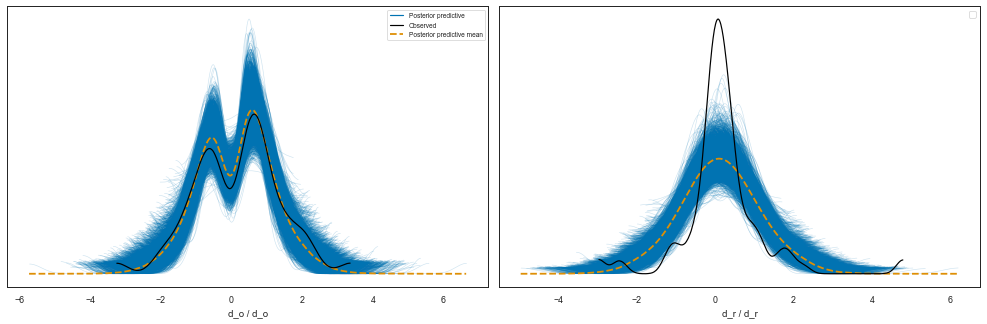

In [378]:
plot_posterior_distribution(idata_psych,save_loc='./output/figures/PosteriorDistributionRPP_alt.png')

In [383]:
from src.simulations import *

In [387]:
out_psych_alt = simulate_alt(idata_psych_alt,save_loc='./output/psych_sims.csv',j=20000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/joebak/anaconda3/envs/rs/lib/python3.10/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


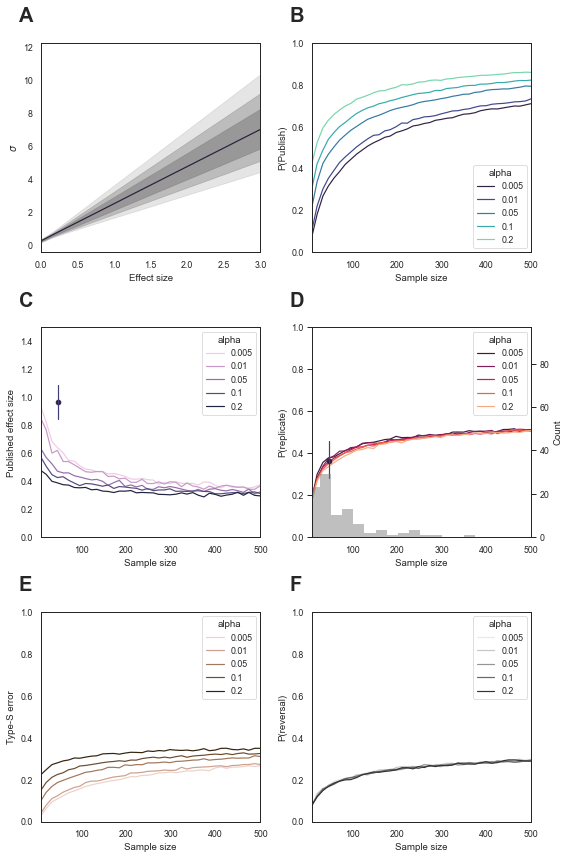

In [388]:
plot_sim_figure_alt(idata_psych_alt, out_psych_alt.to_pandas(),
                df_psych.to_pandas(),save_loc='./output/figures/Figure4_alt.png',max_effect=3)

<h1>Economics RPP</h1>

<h2>Data import</h2>

In [37]:
df_econ = pl.read_csv(('./data/Camerer2016_raw.csv')).filter(
    (pl.col('eorig').is_not_null()) & 
    (pl.col('erep').is_not_null()) &
    (pl.col('nrep_act').is_not_null()) &
    (pl.col('norig').is_not_null()) 
).with_columns([
    (r_to_d(pl.col('erep').cast(float))).alias("d_r"),
    (r_to_d(pl.col('eorig').cast(float))).alias("d_o"),
    pl.col('nrep_act').cast(int).alias("n_r"),
    pl.col('norig').cast(int).alias("n_o"),
]).select([
    'd_o','d_r','n_o','n_r'
])
df_econ['direction'] = np.random.choice([-1,1], size=df_econ.shape[0])

/opt/conda/lib/python3.9/site-packages/polars/internals/frame.py:1561: UserWarning: setting a DataFrame by indexing is deprecated; Consider using DataFrame.with_column
  warnings.warn(


In [38]:
idata_econ,trace_econ,prior_econ, ppc_econ = sample_publishing_model(df_econ,prior={'s':.5,
                                                                        't':.5,
                                                                        'b':.5})

/opt/conda/lib/python3.9/site-packages/polars/internals/frame.py:1345: UserWarning: accessing series as Attribute of a DataFrame is deprecated
  warnings.warn("accessing series as Attribute of a DataFrame is deprecated")
/home/joebak/Projects/ReplicationSurveys/src/modeling.py:42: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_1 = pm.sample(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [signal, noise_r, noise_o, tau, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


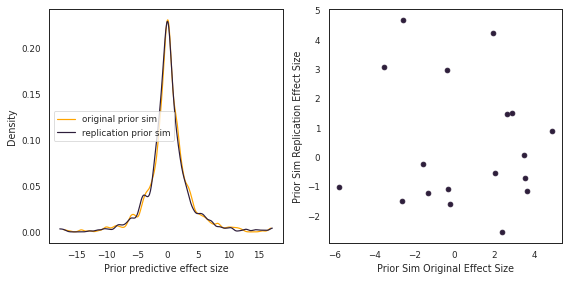

In [39]:
plot_prior_checks(prior_econ, 
                  './output/figures/SIPriorEcon.png')

In [40]:
make_summary_table(idata_econ, 
                   './output/tables/econ_posterior.tex')

/home/joebak/Projects/ReplicationSurveys/src/modeling.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(table.iloc[1] * np.sqrt(2/np.pi),).reset_index()
/home/joebak/Projects/ReplicationSurveys/src/modeling.py:70: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex(save_loc)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
index,,,,,,,,,
sigma,0.84,0.16,0.57,1.14,0.00,0.00,1616.00,1039.00,1.00
tau,1.02,0.26,0.55,1.55,0.01,0.01,1175.00,549.00,1.01
Avg. effect,0.81,0.21,0.44,1.24,0.01,0.00,937.51,438.04,0.81


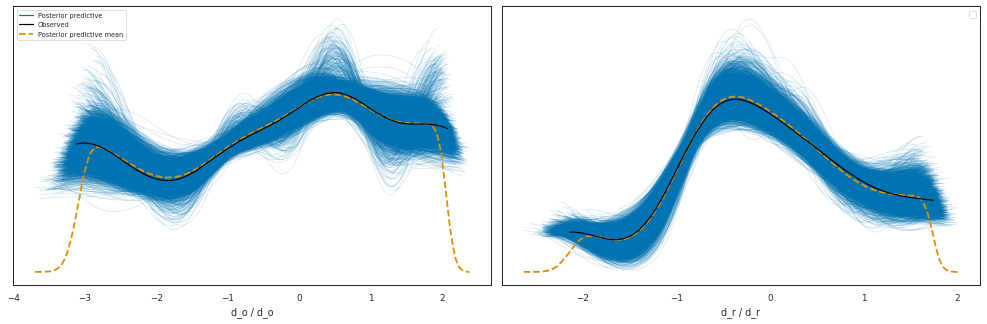

In [41]:
plot_posterior_distribution(idata_econ,
                            save_loc='./output/figures/PosteriorDistributionEcon.png')

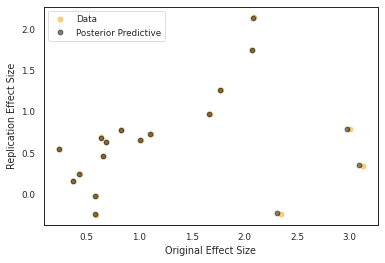

In [42]:
plot_posterior_predictive(df_econ, 
                          ppc_econ, 
                          './output/figures/PosteriorPredictiveEcon.png')

In [43]:
prob_sig = np.mean(
    np.array(
    pl.read_csv(
        ('./data/Camerer2016_raw.csv')
                            
    )['porig'])<.05)
out_econ = simulate(idata_psych,
                    save_loc='./output/econ_sims.csv',
                    prob_sig=prob_sig)
out_econ.head()

publication_rate,replication_rate,type_s_error,published_es,actual_es,reversals,replication_es,N,j,alpha
f64,f64,f64,f64,f64,f64,f64,i64,i64,f64
0.081116,0.346658,0.004,1.427126,1.173038,0.004284,1.1744,10,500,0.005
0.118885,0.3669,0.007307,1.420382,1.161316,0.005,1.159655,10,500,0.01
0.263761,0.352432,0.028611,1.270216,1.058536,0.008547,1.057734,10,500,0.05
0.3604,0.330108,0.051961,1.165418,0.986874,0.009189,0.9862,10,500,0.1
0.487438,0.311527,0.094576,1.051714,0.917062,0.011212,0.919167,10,500,0.2


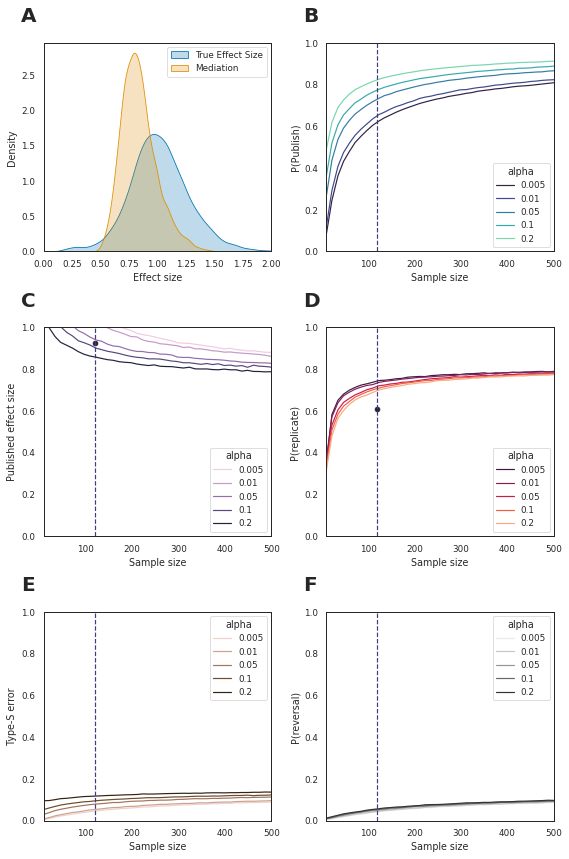

In [44]:
plot_sim_figure(idata_econ, 
                out_econ.to_pandas(), 
                df_econ,
                plot_medians=True,
                rep=.61,
                save_loc='./output/figures/Figure5.png')

<h2>Sampling</h2>

<h1>Preclinical cancer biology</h1>

In [45]:
temp = pl.read_csv('./data/RP_CB Final Analysis - Effect level data.csv',ignore_errors=True)
for column in temp.columns:
    print(column)

Paper #
Experiment #
Effect #
Internal replication #
Effect description
Expected difference based on the original paper?
Observed difference in replication?
Original sample size
Replication sample size
Was a statistical test reported in the original paper?
What statistical test was reported?
Statistical test applied to original data
Original test statistic type
Original test statistic value
Original df1
Original df2
Original p value
Replication statistical test
Replication test statistic type
Replication test statistic value
Replication df1
Replication df2
Replication p value
Was original data representative?
Original point difference (for representative data)
Replication raw difference (if original reported representative data)
Replication raw difference type (mean or median)
Replication raw diference standard error
Replication raw difference lower CI
Replication raw difference upper CI
Effect size type
Original effect size
Original standard error
Original lower CI
Original upper CI
R

In [46]:
#Load RPP Data, randomize direction. 
df_biol = pl.read_csv('./data/RP_CB Final Analysis - Effect level data.csv',ignore_errors=True).with_columns([
    (pl.col('Replication effect size (SMD)').cast(float, strict=False)).alias("d_r"),
    (pl.col('Replication sample size').cast(int)).alias("n_r"),
    pl.col('Original effect size (SMD)').cast(float,strict=False).alias("d_o"),
    pl.col('Original sample size').cast(int,strict=False).alias("n_o"),
]).select([
    'd_o','d_r','n_o','n_r'
]).filter(
    (pl.col('d_o').is_not_null()) & 
    (pl.col('d_r').is_not_null()) &
    (pl.col('n_o').is_not_null()) &
    (pl.col('n_r').is_not_null()) 
)
df_biol.head(5)
df_biol['direction'] = np.random.choice(np.array([-1,1]), df_biol.shape[0])
df_biol.head()

/opt/conda/lib/python3.9/site-packages/polars/internals/frame.py:1561: UserWarning: setting a DataFrame by indexing is deprecated; Consider using DataFrame.with_column
  warnings.warn(


d_o,d_r,n_o,n_r,direction
f64,f64,i64,i64,i64
15.55022,0.2433831,6,10,-1
6.153975,1.728561,6,10,-1
23.24239,1.832289,6,10,-1
7.692164,1.588906,6,10,1
17.08841,0.1037272,6,10,-1


In [47]:
idata_biol,trace_biol,prior_biol, ppc_biol = sample_publishing_model(df_biol,prior={'s':.5,
                                                                        't':.5,
                                                                        'b':.5})

/opt/conda/lib/python3.9/site-packages/polars/internals/frame.py:1345: UserWarning: accessing series as Attribute of a DataFrame is deprecated
  warnings.warn("accessing series as Attribute of a DataFrame is deprecated")
/home/joebak/Projects/ReplicationSurveys/src/modeling.py:42: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_1 = pm.sample(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [signal, noise_r, noise_o, tau, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 219 seconds.
The acceptance probability does not match the target. It is 0.8779109382706998, but should be close to 0.95. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.8260415387833343, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


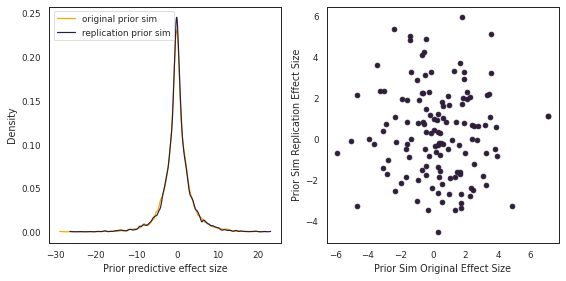

In [48]:
plot_prior_checks(prior_biol, './output/figures/SIPriorBiol.png')

In [49]:
make_summary_table(idata_biol, './output/tables/biol_posterior.tex')

/home/joebak/Projects/ReplicationSurveys/src/modeling.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(table.iloc[1] * np.sqrt(2/np.pi),).reset_index()
/home/joebak/Projects/ReplicationSurveys/src/modeling.py:70: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex(save_loc)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
index,,,,,,,,,
sigma,8.22,0.52,7.24,9.17,0.06,0.05,66.00,506.00,1.05
tau,2.79,1.32,0.11,4.66,0.31,0.22,20.00,25.00,1.15
Avg. effect,2.23,1.06,0.09,3.72,0.25,0.18,15.96,19.95,0.92


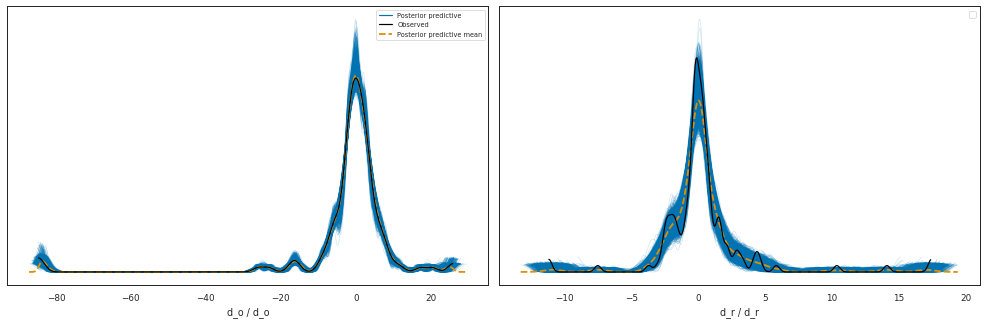

In [50]:
plot_posterior_distribution(idata_biol,
                            save_loc='./output/figures/PosteriorDistributionBiol.png')

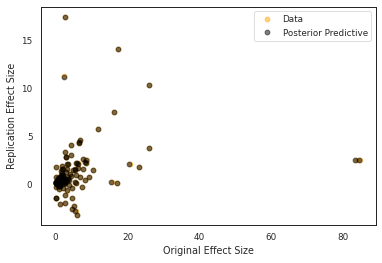

In [51]:
plot_posterior_predictive(df_biol, 
                          ppc_biol, 
                          './output/figures/PosteriorPredictiveBiol.png')

In [52]:
out_biol = simulate(idata_biol,save_loc='./output/biol_sims.csv',prob_sig=136/158)
out_biol.head()

publication_rate,replication_rate,type_s_error,published_es,actual_es,reversals,replication_es,N,j,alpha
f64,f64,f64,f64,f64,f64,f64,i64,i64,f64
0.789093,0.537018,0.305653,2.820674,2.313772,0.328561,2.298604,10,500,0.005
0.815489,0.537958,0.318734,2.7222,2.284946,0.328808,2.315684,10,500,0.01
0.8726,0.536767,0.347446,2.504949,2.230618,0.3328,2.232146,10,500,0.05
0.896887,0.5397,0.357146,2.508955,2.283927,0.331019,2.2837,10,500,0.1
0.922289,0.536973,0.3729,2.385051,2.231715,0.333858,2.233282,10,500,0.2


In [57]:
df_biol['d_o'].median()

2.4844660000000003

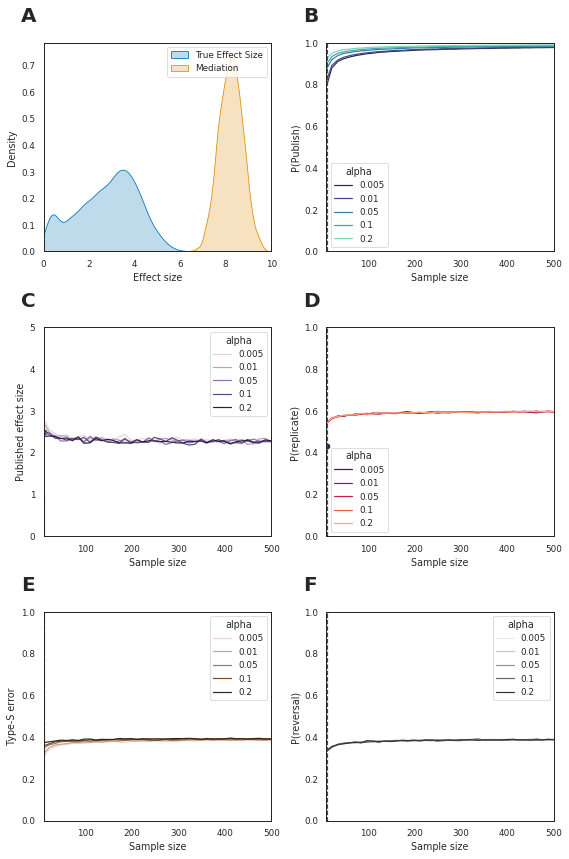

In [58]:
axs = plot_sim_figure(idata_biol, out_biol.to_pandas(), df_biol,
                save_loc='./output/figures/Figure6.png',plot_medians=True,rep=.43, max_effect=10)
